In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(torch.nn.Module): #输入为状态，输出为状态的价值
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 价值网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones) # 时序差分目标
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions)) #返回该状态下采取该动作的概率的对数值
        actor_loss = torch.mean(-log_probs * td_delta.detach()) # 策略网络的损失函数 means()求均值 就是求期望的意思 torch.mean() 一定要加，这里是个序列
        #td_delta.detach() 这里.datach()可加可不加，因为在计算actor_loss时，td_delta不需要梯度，所以加上detach()是为了提高效率

#detach()返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置，不同之处只是requires_grad为false，
#得到的这个Variable永远不需要计算其梯度，不具有grad。

        # 均方误差损失函数           #mse_loss均方误差    #时序差分目标不作为梯度传递
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach())) #价值网络的损失函数 两个参数input和target #这里torch.mean()可不加
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad() # 梯度清零
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [5]:
from tqdm import tqdm
#  train_on_policy_agent函数用于训练on-policy agent
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset(seed =0)[0] #1.改 看gym版本0.26.2版本的 多了一个info
                #print(state)
                done = False
                while not done:
                    action = agent.take_action(state) 
                    #next_state, reward, done, _ = env.step(action)# gym版本0.26.2版本以前的
                    next_state, reward,terminated, truncated, _ = env.step(action) #2.改看gym版本0.26.2版本的 
                    done = terminated or truncated
                    #print(next_state, reward, done)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
print(device)

cuda


In [7]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
print(device)

env_name = 'CartPole-v1' #v0最大分数为200 v1最大分数为500
env = gym.make(env_name)
#env.seed(0) #3.改
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 100/100 [00:00<00:00, 184.32it/s, episode=100,
# return=21.100]
# Iteration 1: 100%|██████████| 100/100 [00:01<00:00, 98.31it/s, episode=200,
# return=72.800]
# Iteration 2: 100%|██████████| 100/100 [00:01<00:00, 58.72it/s, episode=300,
# return=109.300]
# Iteration 3: 100%|██████████| 100/100 [00:04<00:00, 23.14it/s, episode=400,
# return=163.000]
# Iteration 4: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s, episode=500,
# return=193.600]
# Iteration 5: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s, episode=600,
# return=195.900]
# Iteration 6: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s, episode=700,
# return=199.100]
# Iteration 7: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s, episode=800,
# return=186.900]
# Iteration 8: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s, episode=1000,
# return=200.000]

cuda


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\REM\AppData\Local\Temp\ipykernel_18856\2341701497.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
d:\softwares\anaconda3\envs\myrl\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s, episode=1000, return=500.000]


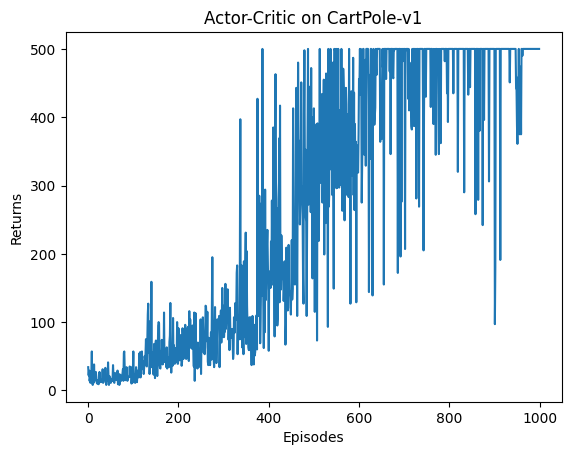

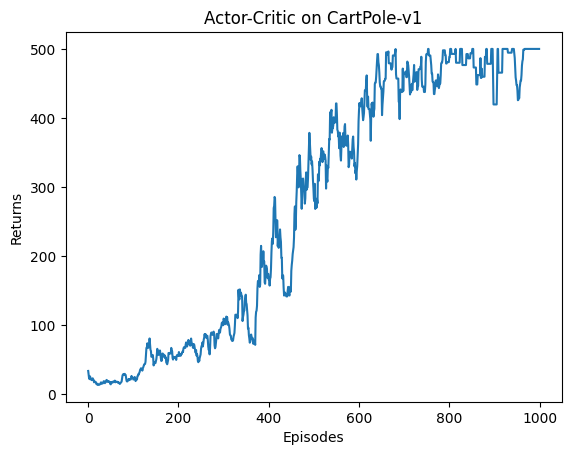

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

In [2]:
import torch
print(torch.__version__)

2.2.2+cu121


In [28]:
import torch
import gym
print(torch.__version__)
print(torch.cuda.is_available())
print(type(gym.__version__))


2.2.2+cu121
True
<class 'str'>


In [34]:
import gym
env = gym.make('CartPole-v0', render_mode = "human") #render_mode = "human"和env.render()一起使用才有画面
for episode in range(10):
  env.reset()
  print("Episode finished after {} timesteps".format(episode))
  for _ in range(100):
    env.render()
    env.step(env.action_space.sample())
env.close()


Episode finished after 0 timesteps
Episode finished after 1 timesteps


KeyboardInterrupt: 

In [ ]:
import torch

# 创建一个二维张量
tensor = torch.tensor([[1, 2], [3, 4]])

# 计算所有元素的均值，输出为标量
mean_val = torch.mean(tensor)
print(mean_val)  # 输出: tensor(2.5000)

# 计算每列的均值，输出为一维张量
mean_val_dim0 = torch.mean(tensor, dim=0)
print(mean_val_dim0)  # 输出: tensor([2., 3.])

# 计算每行的均值，输出为一维张量
mean_val_dim1 = torch.mean(tensor, dim=1)
print(mean_val_dim1)  # 输出: tensor([1.5000, 3.5000])
